# Physics 305 Demo Notebook 3: Calculating the Mean Square Displacement (MSD) from a Time-Series - Brownian Motion

The mean square deviation or MSD is defined to be:
$ \langle x^2 \rangle - \langle x \rangle^2 $. This is also known as the *structure function*.

Recall that for any two points $x_i$ and $x_j$, we define the lag time $\tau$ to be $t_j - t_i$.

Then, for Brownian motion, MSD $= 2D\tau$ (Eq. 1), where $D$ is the diffusion coefficient. Recall also that the PDF for a given lag time $\tau$ is a Gaussian with a standard deviation of MSD$^{1/2} = \sqrt{2D\tau}$ (as derived in class and illustrated in Demo Notebook #2).

Let us now also define $\Delta$ to be the number of time steps equivalent to the lag time $\tau$, i.e., $\tau = \Delta*dt$, where $dt$ is the size of the time step.

We introduce the empirical definition of the MSD as a function of $\Delta$ (Eq. 2):

MSD$(\Delta) = \frac{1}{n-\Delta} \Sigma_{j=0}^{j=n-1-\Delta} \left( x_{j+\Delta}-x_j\right)^2$

Here, we will calculate the MSD as a function of lag time (using Eq. 2) for standard Brownian motion samples and compare them with the analytical result. Recall that for standard Brownian motion, $D=1/2$, so we expect (from Eq. 1):

MSD$(\tau) = 2D\tau = \tau$.

This is simply a linear relation with a slope of 1.

### Step 1: Generate Brownian motion samples

In [1]:
# import libraries
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Set random seed
np.random.seed(seed=17)

# Set parameters
n_samp = 10 # no. of samples/realizations
n = int(1e6)  # no. of timesteps
dt = 1.  # size of time step
sd = np.sqrt(dt) # standard deviation
t = dt*np.arange(n) # time

# Initialize array to hold the BM samples
x_samp = np.zeros((n, n_samp))

# Loop over realizations
for i in np.arange(n_samp):
  # Generate random numbers from Gaussian distribution centered at 0 and standard deviation sd
  rnd = norm.rvs(size = n, scale = sd)
  # Get cumulative sum of the elements of the array of random numbers
  x_samp[:, i] = np.cumsum(rnd)

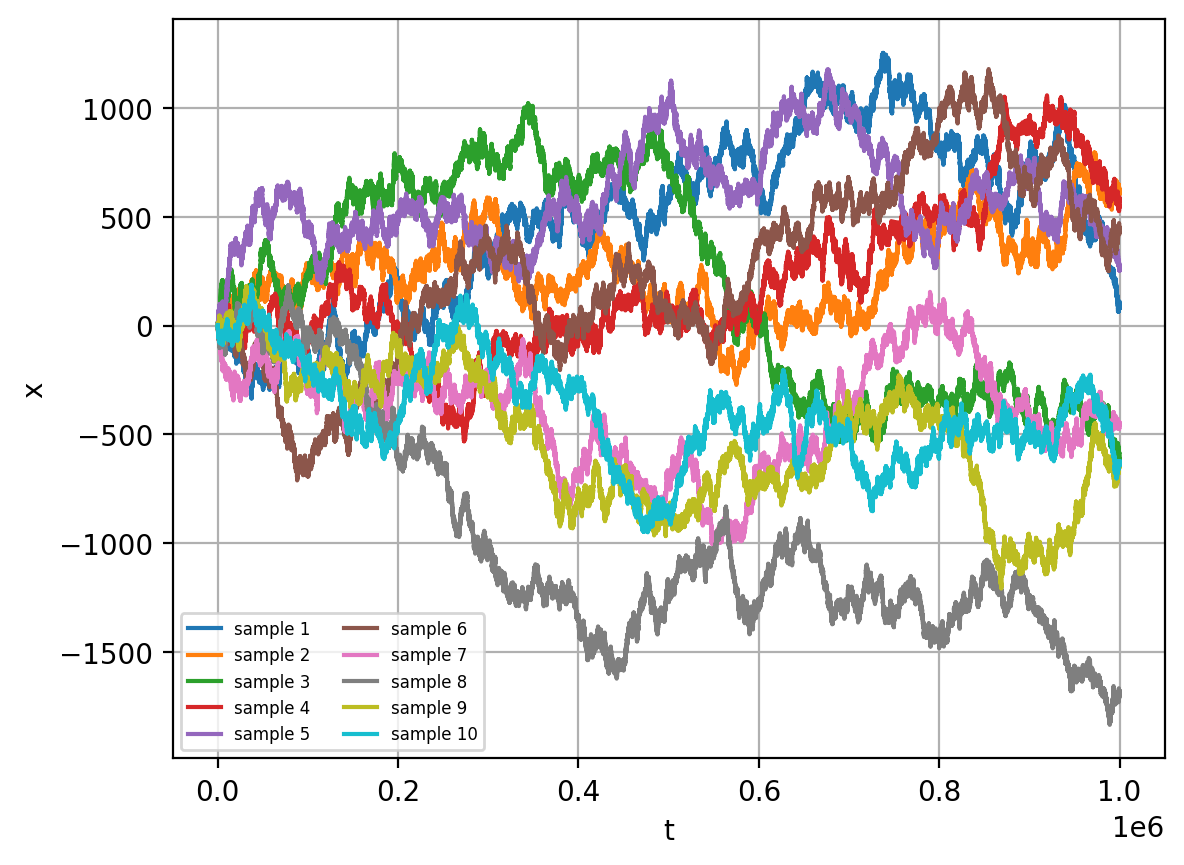

In [3]:
# Plot BM samples
plt.figure(dpi = 200)
plt.grid()
for i in np.arange(n_samp):
  plt.plot(t, x_samp[:, i],label="sample %d" % (i+1))
plt.xlabel("t")
plt.ylabel("x")
plt.legend(loc="lower left", ncol=2, fontsize=6)

### Step 2: Generate the MSD

First, let us define the range of lag times to calculate the MSD for. Recall that when we calculated the displacement probability distributions (PDFs) in Demo Notebook #2, we selected $\tau = 10, 10^2, 10^3, 10^4, 10^5, 9 \times 10^5$.

We found that for $\tau = 10^3$ and lower, there is a very good match between the calculated and analytical results, even for a single realization (but this does not necessarily hold for larger lag times).

Here, let us calculate the MSD for $1 \le \tau \le 9 \times 10^5$ and indicate the regime $\tau < 10^3$ (to remind us that small-number statistics is affecting large lag times).

Computationally, we will do this for an grid of $\tau$ values *equally-spaced in log scale*. Let us also perform the calculation for all $n_{\rm samp}=10$ samples.

In [4]:
n_tau = 100
tau_vals = np.logspace(0, np.log10(9e5), n_tau)
delta_vals = np.round(tau_vals/dt).astype(int)

tau_vals

array([1.00000000e+00, 1.14853402e+00, 1.31913040e+00, 1.51506614e+00,
       1.74010500e+00, 1.99856979e+00, 2.29542540e+00, 2.63637416e+00,
       3.02796541e+00, 3.47772129e+00, 3.99428121e+00, 4.58756786e+00,
       5.26897775e+00, 6.05160020e+00, 6.95046871e+00, 7.98284976e+00,
       9.16857453e+00, 1.05304198e+01, 1.20945453e+01, 1.38909968e+01,
       1.59542824e+01, 1.83240361e+01, 2.10457788e+01, 2.41717930e+01,
       2.77621265e+01, 3.18857468e+01, 3.66218650e+01, 4.20614578e+01,
       4.83090152e+01, 5.54845475e+01, 6.37258903e+01, 7.31913530e+01,
       8.40627589e+01, 9.65489385e+01, 1.10889740e+02, 1.27360639e+02,
       1.46278027e+02, 1.68005291e+02, 1.92959792e+02, 2.21620885e+02,
       2.54539126e+02, 2.92346846e+02, 3.35770298e+02, 3.85643611e+02,
       4.42924807e+02, 5.08714209e+02, 5.84275575e+02, 6.71060375e+02,
       7.70735671e+02, 8.85216138e+02, 1.01670085e+03, 1.16771551e+03,
       1.34116099e+03, 1.54036903e+03, 1.76916623e+03, 2.03194761e+03,
      

Similar to what we did when calculating the PDFs, we get the displacements for all $\tau$ values and samples.

In [5]:
# initialize array to store displacements
# note that the size n is larger than the actual number of values to be stored
# values are initialized to NaN (which are not included in the MSD calculation)
dx_tau = np.empty((n, n_tau, n_samp))*np.nan

for i_samp in np.arange(n_samp):
  for i, tau in enumerate(tau_vals):
    delta = delta_vals[i]

    # get truncated copy of x, ending in initial data point of the last pair
    x_trunc = x_samp[:-1*delta, i_samp]

    # get shifted copy of x, starting from end data point of the first pair
    x_shift = x_samp[delta:, i_samp]

    # get displacements
    dx = x_shift - x_trunc

    # store in output array
    dx_tau[:len(dx), i, i_samp] = dx

    #print(i, tau, delta, len(dx))

In [6]:
np.shape(dx_tau)

(1000000, 100, 10)

Next, we get the mean of the squared displacements for each value of $\tau$:

In [7]:
# initialize array to store MSD values
msd_tau = np.empty((n_tau, n_samp))*np.nan

for i_samp in np.arange(n_samp):
  for i, tau in enumerate(tau_vals):
    dx2_sum = np.nansum(dx_tau[:, i, i_samp]**2) # returns sum treating NaNs as zero
    denom = n-delta_vals[i]
    msd_tau[i, i_samp] = dx2_sum/denom

In [8]:
np.shape(msd_tau)

(100, 10)

Finally, we plot the MSD as a function of $\tau$ for the different samples and overlay the analytical result MSD$(\tau) = \tau$.

Text(0, 0.5, 'MSD')

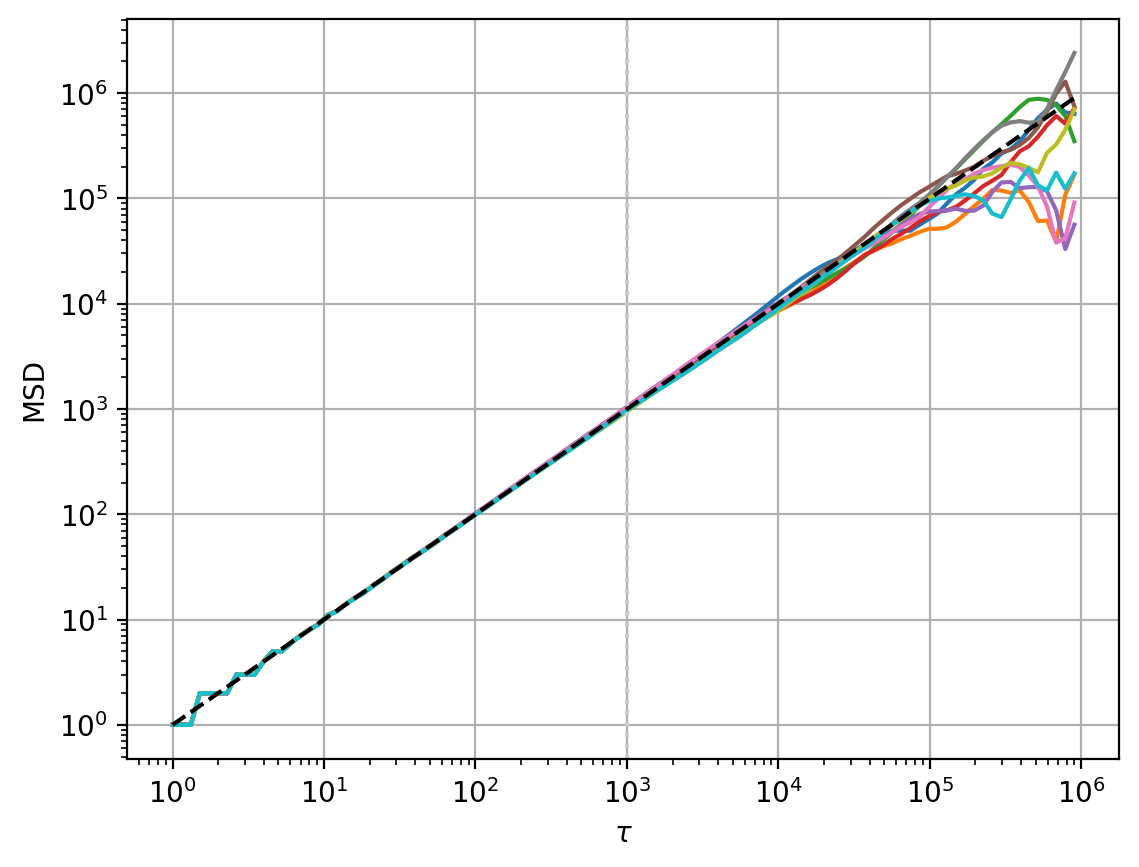

In [10]:
# plot MSD for all realizations
plt.figure(dpi = 200)
plt.grid()

for i_samp in np.arange(n_samp):
  plt.plot(tau_vals, msd_tau[:, i_samp])

# plot analytical result
msd_theo = tau_vals
plt.plot(tau_vals, msd_theo, 'k--')

# plot vertical line at tau=10^3
tau_ref = 1e3
plt.axvline(tau_ref, color='0.8', ls=':')

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\tau$")
plt.ylabel("MSD")

We find deviations from the analytical result for large values of $\tau$, as expected from the smaller number of data point pairs used in this regime.

Zooming in on $\tau < 10^3$, we find deviations from the analytical result for individual simulations, as expected, but a good match to the average MSD curve (over all realizations).  

In [11]:
# get the average MSD over all realizations
msd_mean = np.mean(msd_tau, axis=1)
np.shape(msd_mean)

(100,)

(1.0, 1000.0)

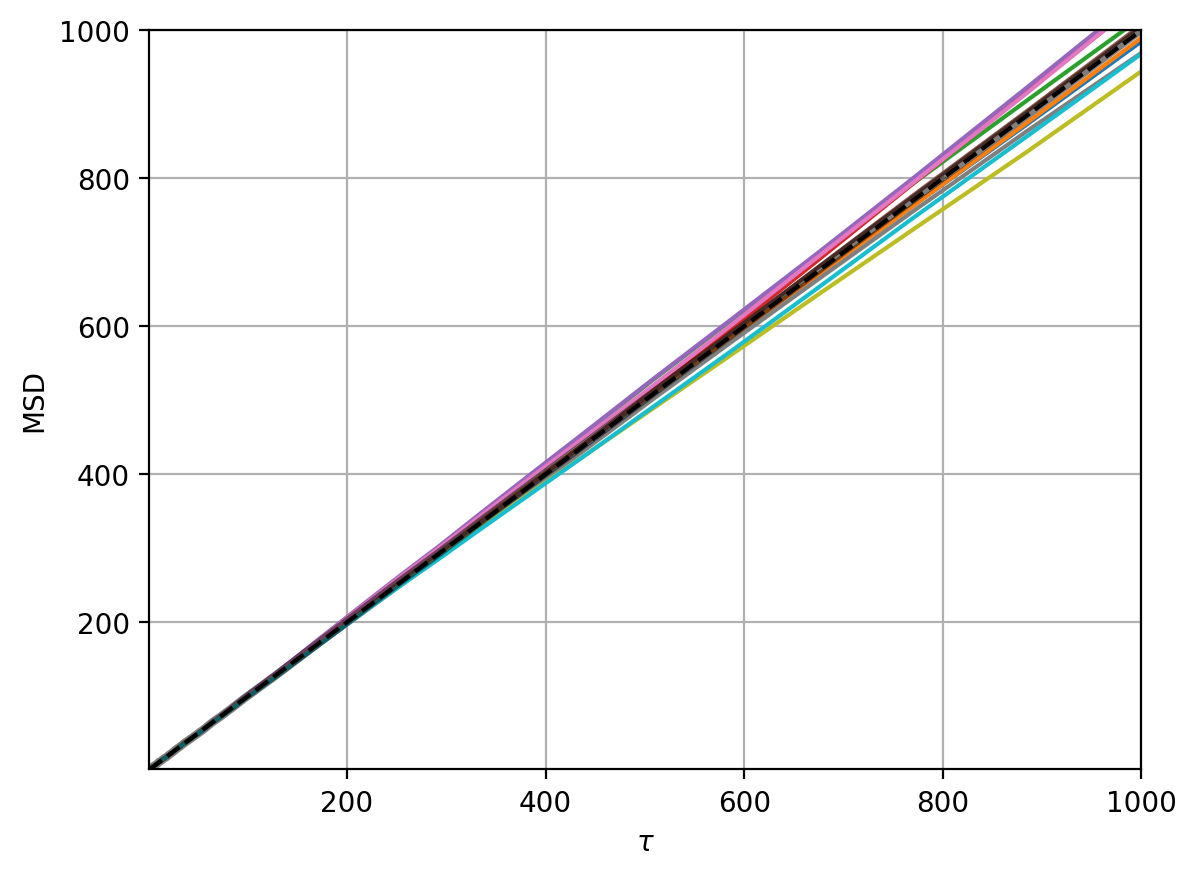

In [12]:
# plot MSD for all realizations
plt.figure(dpi = 200)
plt.grid()
for i_samp in np.arange(n_samp):
  plt.plot(tau_vals, msd_tau[:, i_samp])

# plot average MSD over all realizations
plt.plot(tau_vals, msd_mean, color='k', lw=3, alpha=0.5)

# plot analytical result
msd_theo = tau_vals
plt.plot(tau_vals, msd_theo, 'k--')

#plt.xscale("log")
#plt.yscale("log")
plt.xlabel(r"$\tau$")
plt.ylabel("MSD")

plt.xlim((1, 1e3))
plt.ylim((1, 1e3))

(-55.0, 55.0)

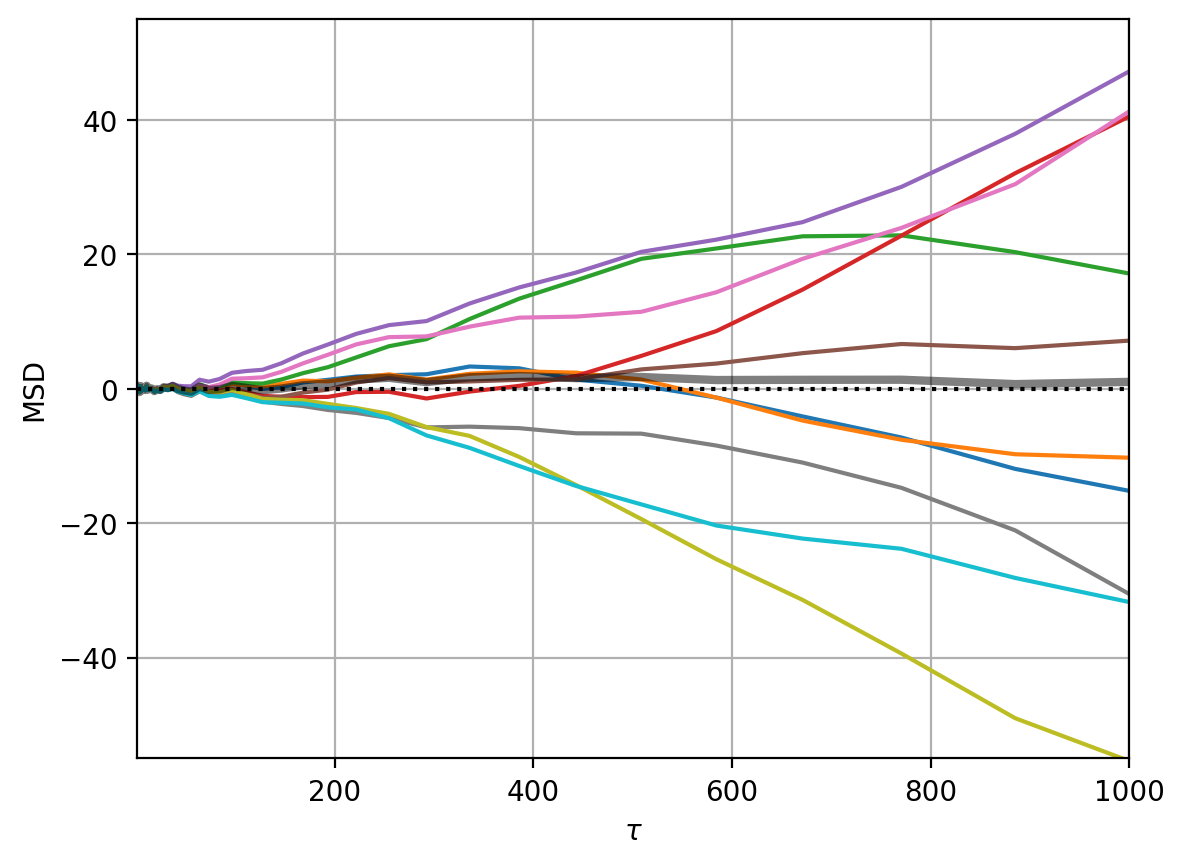

In [13]:
# plot residuals from analytical result
plt.figure(dpi = 200)
plt.grid()
# plot MSD for all realizations
for i_samp in np.arange(n_samp):
  plt.plot(tau_vals, msd_tau[:, i_samp]-msd_theo)

# plot average MSD over all realizations
plt.plot(tau_vals, msd_mean-msd_theo, color='k', lw=3, alpha=0.5)

# plot horizontal line at zero
plt.axhline(0., color='k', ls=':')

plt.xlabel(r"$\tau$")
plt.ylabel("MSD")

plt.xlim((1, 1e3))
plt.ylim((-55, 55))